In [67]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [68]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [69]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)

data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [70]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [71]:
# Re-encoding SNP of interest

df.loc[df.PHENOTYPE == 2, ['rs2222162']] = 2
df.loc[df.PHENOTYPE == 1, ['rs2222162']] = 0

In [72]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])
dfT = dfTest.T

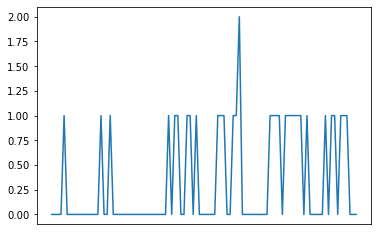

In [73]:
# Visualising entry 1 which is a control 
dfT[0]=dfT[0].astype(float)
dfT[0].plot(xlabel=None) 
plt.gca().axes.get_xaxis().set_visible(False)

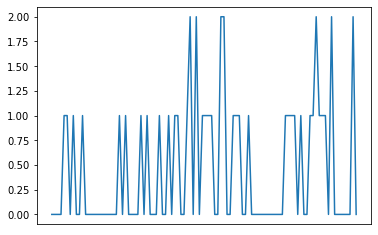

In [74]:
# Visualising entry 2 which is a control 
dfT[1]=dfT[1].astype(float)
dfT[1].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

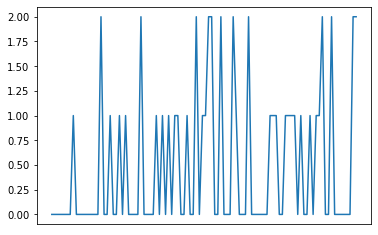

In [75]:
# Visualising entry 3 which is a case

dfT[2]=dfT[2].astype(float)
dfT[2].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

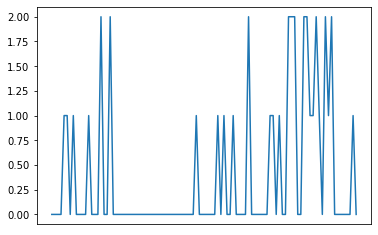

In [76]:
# Visualising entry 87 which is a case

dfT[86]=dfT[86].astype(float)
dfT[86].plot() 
plt.gca().axes.get_xaxis().set_visible(False)

In [77]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy='most_frequent')
idf = pd.DataFrame(imp.fit_transform(dfTest))

In [78]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [79]:
# Classifying GWAS data using decision tree and printing results

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtc.fit(xTrain, yTrain)
yPredicted = dtc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = dtc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.8301886792452831
Testing accuracy score: 0.5833333333333334
[[10  5]
 [10 11]]


In [80]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier() 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.7169811320754716
Testing accuracy score: 0.6388888888888888
[[11  4]
 [ 9 12]]


In [81]:
# Classifying GWAS data using Gaussian Naive Bayes and printing results

gnbClf = GaussianNB() 
gnbClf.fit(xTrain, yTrain)
yPredicted = gnbClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = gnbClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.5660377358490566
Testing accuracy score: 0.4722222222222222
[[ 2 13]
 [ 6 15]]


In [82]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [83]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, y_test = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [84]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=['index'])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=['index'])

In [85]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [86]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

C:\Users\emjcu\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Accuracy with Rocket: 0.528
[[10  5]
 [12  9]]
              precision    recall  f1-score   support

           1       0.45      0.67      0.54        15
           2       0.64      0.43      0.51        21

    accuracy                           0.53        36
   macro avg       0.55      0.55      0.53        36
weighted avg       0.56      0.53      0.53        36



In [87]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with MrSEQL: 0.528
[[ 9  6]
 [11 10]]
              precision    recall  f1-score   support

           1       0.45      0.60      0.51        15
           2       0.62      0.48      0.54        21

    accuracy                           0.53        36
   macro avg       0.54      0.54      0.53        36
weighted avg       0.55      0.53      0.53        36

